In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


In [2]:
%matplotlib widget

In [3]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


spin_groups = [ (3.0,1,0) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   


E_min_max = [75, 125]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

# experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
#                          'n':  {'val':0.067166,     'unc'   :0}}
experiment_parameters = {'bw': {'val':0.1024,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/TestFMReduction2.hdf5'
dataset_range = (0, 10)
samples_not_generated = generate(Ta_pair, exp, 
                                        'syndat_SLBW', 
                                        dataset_range, 
                                        case_file,
                                        fixed_resonance_ladder=None, 
                                        open_data=None,
                                        vary_Erange=None,
                                        use_hdf5=True,
                                        overwrite = False
                                                                    )

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

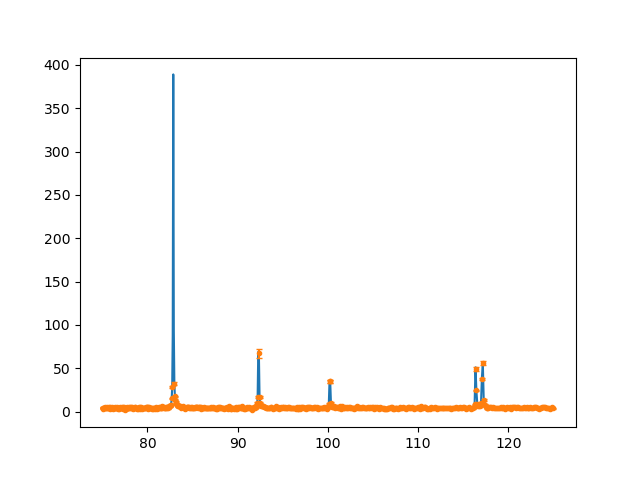

In [4]:
import ATARI.atari_io.hdf5 as io
from ATARI.utils.misc import fine_egrid 
from ATARI.utils.io.datacontainer import DataContainer
from ATARI.utils.io.pointwise import PointwiseContainer
from ATARI.utils.io.parameters import TheoreticalParameters, ExperimentalParameters


# read hdf
# casenum = 5
# theo_resladder = pd.read_hdf(case_file, f'sample_{casenum}/theo_par')
# exp_pw, exp_cov = io.read_experimental(case_file, casenum)

# read Oleksii's Data
casenum = 114
filepath = f"/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/sample_{casenum}"
theo_resladder = pd.read_csv(os.path.join(filepath, 'ladder.csv'), index_col=0)
exp_cov = pd.read_csv(os.path.join(filepath, 'cov.csv'), index_col=0)
exp_pw = pd.read_csv(os.path.join(filepath, 'transm.csv'), index_col=0)
exp_pw.rename(columns={'exp_cs':'exp_xs', 'theo_cs':'theo_xs'}, inplace=True)
exp_cov.columns=exp_pw.E
exp_cov.index=exp_pw.E
exp_cov.index.name = None



threshold_0T = 1e-2
exp_par = ExperimentalParameters(0.067166, 0, threshold_0T)
theo_par = TheoreticalParameters(Ta_pair, theo_resladder, 'theo')
# est_par = TheoreticalParameters(Ta_pair, theo_resladder, 'est')

pwfine = pd.DataFrame({'E':fine_egrid(exp_pw.E,100)})
pw = PointwiseContainer(exp_pw, pwfine)
pw.add_experimental(exp_pw, exp_cov, exp_par)
pw.add_model(theo_par, exp_par)


dc = DataContainer(pw, exp_par, theo_par,{})
# test = DataContainer(pw, exp_par, theo_par)

figure()
# plot(pw.fine.E, pw.fine.theo_xs)
plot(dc.pw.exp.E, dc.pw.exp.theo_xs)
errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.')
# ylim([-max_xs*.1, max_xs*1.25])


In [5]:

import classes as cls

## Approach

0. Solve initial and reduce feature bank (don't want to do this step but I am for now to speed up computation)

1. Solve unconstrained problem with 'full' feature bank. 

2. Run bisection routine to get solutions constrained to different number of features (Resonances)
    a. Maximum possible weight comes from 1.
    b. Solve for the minimum possible weight constraint using LP. 

3. For each solution corresponding to an integer number of features, reduce the feature bank and solve the unconstrained problem

4. For each solution from 3 as a prior, solve the GLLS problem to search the constinuous parameter space

5. Perform LRT between the models from 4

In [6]:
### Unit test for feature bank construction

# fb0 = prob.get_FeatureBank(dc, [575], [100e-3])
# # inp0 = prob.get_MatrixInputs(dc, fb0)
# fb0.solution_ws = np.array([50e-3])
# test_par = TheoreticalParameters(Ta_pair, pd.DataFrame({'E':575, 'Gt':100, 'Gnx':50, 'Gg':50, 'J':3.0,'chs':1,'lwave':0.0, 'J_ID':None}, index=[0]))
# test,_,_ = SLBW(dc.pw.exp.E, Ta_pair, test_par.resonance_ladder)

# figure()
# plot(dc.pw.exp.E, fb0.model-test)
# # plot(dc.pw.exp.E, test)


## Step 0, reduce initial feature bank for computational speed

In [7]:
### Step 0
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(exp_pw.E, average_parameters, '3.0', 2e0, 3e0)
Gtot_features = np.append(Gtot_features, np.round(np.array(theo_resladder.Gt),1)*1e-3 )
Elam_features = np.append(Elam_features, np.round(np.array(theo_resladder.E),1))
# Elam_features = np.round(np.array(theo_resladder.E),1)
# Gtot_features = np.array(theo_resladder.Gt)*1e-3
# Elam_features = np.array(theo_resladder.E)

w_threshold = 1e-6
prob = cls.ProblemHandler(w_threshold)

fb0 = prob.get_FeatureBank(dc, Elam_features, Gtot_features)
inp0 = prob.get_MatrixInputs(dc, fb0)

sol_lp0 = cls.Solvers.solve_linear_program(inp0)
print(fb0.nfeatures)
print(np.count_nonzero(sol_lp0>0))
Gtot_features

540
281


array([0.0575304, 0.0605304, 0.0635304, 0.0665304, 0.0695304, 0.0725304,
       0.0755304, 0.0785304, 0.0815304, 0.0845304, 0.0875304, 0.0905304,
       0.0935304, 0.0656   , 0.0733   , 0.0634   , 0.0645   , 0.0716   ])

In [8]:
sol_lp0

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05747287, 0.06046987, 0.06346

## Step 1, solve unconstrained problem

In [9]:
qpopt = cls.QPopt(verbose=True,
                abstol = 1e-8,
                reltol = 1e-8,
                feastol=1e-7,
                    maxiters = 200)

In [10]:
### Step 1
fb1, sol_lp0_ereduced = prob.reduce_FeatureBank(fb0, sol_lp0)
inp1 = prob.get_MatrixInputs(dc, fb1)
# fb1 = fb0
# inp1 = inp0
fb1.solution_ws = cls.Solvers.solve_quadratic_program(inp1, qpopt)
# print(fb1.nfeatures)
# fb1.get_parameter_solution()

     pcost       dcost       gap    pres   dres
 0: -2.8891e+03 -2.7703e+03  3e+04  2e+00  4e-01
 1: -2.9287e+03 -3.1310e+03  9e+03  4e-01  1e-01
 2: -2.9198e+03 -3.0201e+03  2e+03  8e-02  2e-02
 3: -2.9188e+03 -3.0290e+03  2e+03  7e-02  2e-02
 4: -2.9148e+03 -3.0182e+03  8e+02  3e-02  7e-03
 5: -2.9178e+03 -3.0460e+03  5e+02  1e-02  3e-03
 6: -2.9137e+03 -2.9937e+03  3e+02  5e-03  1e-03
 7: -2.9059e+03 -2.9673e+03  2e+02  4e-03  1e-03
 8: -2.8966e+03 -2.9350e+03  1e+02  2e-03  6e-04
 9: -2.8911e+03 -2.9242e+03  1e+02  2e-03  5e-04
10: -2.8845e+03 -2.9091e+03  1e+02  1e-03  4e-04
11: -2.8782e+03 -2.8913e+03  8e+01  9e-04  2e-04
12: -2.8717e+03 -2.8703e+03  7e+01  7e-04  2e-04
13: -2.8641e+03 -2.8489e+03  7e+01  6e-04  2e-04
14: -2.8530e+03 -2.8436e+03  7e+01  5e-04  1e-04
15: -2.8478e+03 -2.8294e+03  8e+01  4e-04  1e-04
16: -2.8432e+03 -2.8143e+03  8e+01  4e-04  1e-04
17: -2.8244e+03 -2.7785e+03  8e+01  3e-04  7e-05
18: -2.7865e+03 -2.6860e+03  1e+02  2e-04  6e-05
19: -2.7726e+03 -2.66

In [11]:
fb1.solution_ws
# fb1.feature_matrix
# sol_lp0_ereduced
# fb1.feature_matrix

array([2.16973629e-16, 2.12946067e-17, 2.11661702e-17, 2.13315741e-17,
       2.14957644e-17, 2.16838790e-17, 2.19161728e-17, 2.22058320e-17,
       2.25172762e-17, 2.28952007e-17, 2.33161575e-17, 2.37681280e-17,
       2.47255344e-17, 2.12783522e-17, 2.17397734e-17, 2.11613428e-17,
       2.12144426e-17, 2.16206800e-17, 8.36348218e-15, 9.23496356e-15,
       1.02950302e-14, 1.16029818e-14, 1.32479364e-14, 1.53697760e-14,
       1.82008752e-14, 2.21574539e-14, 2.80666892e-14, 3.78442676e-14,
       5.71982715e-14, 1.15067074e-13, 8.92477772e-06, 1.11662123e-14,
       1.60160521e-14, 1.02443139e-14, 1.06870968e-14, 1.46491987e-14,
       4.12781948e-14, 4.28031086e-14, 4.50166874e-14, 4.80648575e-14,
       5.21864246e-14, 5.77701545e-14, 6.54677306e-14, 7.64322206e-14,
       9.28714092e-14, 1.19508006e-13, 1.68186117e-13, 2.77560946e-13,
       1.22590314e-05, 4.70181379e-14, 5.95086586e-14, 4.49044500e-14,
       4.59013228e-14, 5.58497447e-14, 3.74146239e-06, 1.15055819e-13,
      

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


15

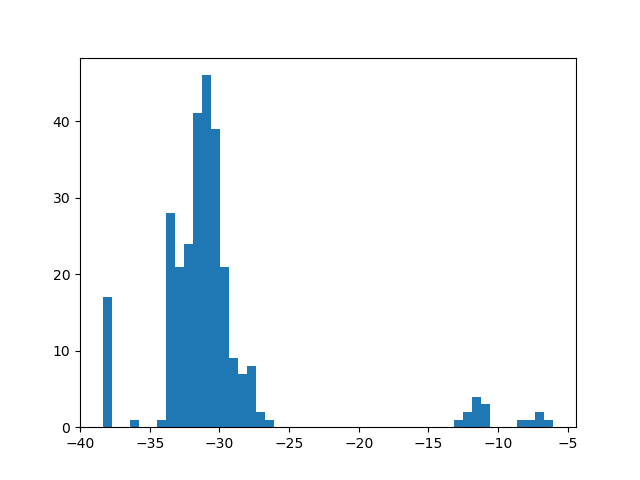

In [12]:
figure()
# plot(dc.pw.exp.E, dc.pw.exp.theo_xs, 'g')
# errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw.exp.E, fb1.model, 'r')
bins = hist(np.log(fb1.solution_ws), bins=50)
np.count_nonzero(fb1.solution_ws>prob.w_threshold)

In [13]:
def solve_qp_w_constraint(inp_uncon, wcon, qpopt: cls.QPopt):
    inp_con = prob.get_ConstrainedMatrixInputs(inp_uncon, wcon)
    sol = cls.Solvers.solve_quadratic_program(inp_con, qpopt)
    return sol

## Step 2, run bisection routine

In [14]:
### Bisection Routine
def bisect(x0,x1):
    return (x0+x1)/2

def bisect_and_solve(current_target_ires, minval, maxval, target_numres, wcon, sol_ws, save_all, searching=True, termination_threshold=1e-3):

    icurrent_target_ires = current_target_ires-min(target_numres)
    
    while searching:

        # check termination criteria
        if abs((minval-maxval)/maxval) < termination_threshold:
            searching = False
        elif wcon[icurrent_target_ires] > 0:
            searching = False

        # bisect, solve, and save result
        new_w = bisect(minval, maxval)
        con_sol_ws = solve_qp_w_constraint(inp1, new_w, qpopt) # TODO: Make dc and fb dynamic here!
        if con_sol_ws is None:
            wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, wcon, sol_ws, save_all, searching=searching)
        else:
            numres_sol = np.count_nonzero(con_sol_ws>w_threshold)
            ires_sol = numres_sol-min(target_numres)
            save_all.append((new_w, numres_sol))

            if numres_sol == current_target_ires:
                #record if current target
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws

            elif numres_sol > current_target_ires:
                # record other if in target numres
                if numres_sol in target_numres:
                    if wcon[ires_sol] < new_w:
                        wcon[ires_sol] = new_w
                        sol_ws[:,ires_sol] = con_sol_ws
                # bisect again to find current target
                wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, minval, new_w, target_numres, wcon, sol_ws, save_all, searching=searching)

            elif numres_sol < current_target_ires:
                # record other if in target numres
                if numres_sol in target_numres:
                    if wcon[ires_sol] < new_w:
                        wcon[ires_sol] = new_w
                        sol_ws[:,ires_sol] = con_sol_ws
                # bisect again to find current target
                wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, wcon, sol_ws, save_all, searching=searching)

    return wcon, sol_ws, save_all, searching

def get_bounding_wcons(ires_target, save_all):
    temp = np.array(save_all)
    temp = temp[temp[:,0].argsort()]
    index = np.searchsorted(temp[:,1], ires_target, side='left')
    return temp[index-1,0], temp[index,0]

def get_target_numres_array(target_maxres, max_numres, min_numres):
    return np.arange(min_numres, np.min([target_maxres,max_numres])+1, 1)

def get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, max_numres, max_wcon, max_solw, target_wcon=None, sol_ws = None):
    if target_wcon is None and sol_ws is None:
        # init targer w constraints and solution vectors
        target_wcon = np.zeros(len(target_numres))
        sol_ws = np.zeros((len(min_wcon_solw), len(target_numres)))
        # add min wconstraint and solution
        if min_wcon == 0:
            min_wcon = 1e-10
        target_wcon[0] = min_wcon
        sol_ws[:, 0] = min_wcon_solw
        # add max if max numres (unconstrained solve) is in the target
        if max_numres in target_numres:
            target_wcon[-1] = max_wcon
            sol_ws[:, -1] = max_solw
    
    elif target_wcon is None or sol_ws is None:
        raise ValueError("Either target_wcon or sol_ws is None while the other is populated, check input.")
    else:
        elements_to_add = len(target_numres)-len(target_wcon)
        assert elements_to_add >= 0, "target_numres is shorter than target_wcon"
        target_wcon = np.append(target_wcon, [0]*elements_to_add)
        sol_ws = np.append(sol_ws, np.zeros((np.shape(sol_ws)[0], elements_to_add)), axis=1)
    return target_wcon, sol_ws

In [15]:
### Step 2

w_threshold = 1e-6
# determine mins and maxes
min_wcon = prob.get_MinSolvableWeight(fb1.nfeatures, inp1)
max_wcon = np.sum(fb1.solution_ws)
max_numres = np.count_nonzero(fb1.solution_ws>prob.w_threshold)
min_wcon_solw = solve_qp_w_constraint(inp1, min_wcon*1.01, qpopt)
min_numres = np.count_nonzero(min_wcon_solw>prob.w_threshold)


# solve_qp_w_constraint(inp1, min_wcon*1.001, qpopt)
print(min_numres)
print(max_numres)

     pcost       dcost       gap    pres   dres
 0: -2.8891e+03 -2.7703e+03  3e+04  2e+00  4e-01
 1: -2.9287e+03 -3.1310e+03  9e+03  4e-01  1e-01
 2: -2.9198e+03 -3.0201e+03  2e+03  8e-02  2e-02
 3: -2.9188e+03 -3.0290e+03  2e+03  7e-02  2e-02
 4: -2.9148e+03 -3.0182e+03  8e+02  3e-02  7e-03
 5: -2.9178e+03 -3.0459e+03  5e+02  1e-02  3e-03
 6: -2.9137e+03 -2.9937e+03  3e+02  5e-03  1e-03
 7: -2.9059e+03 -2.9673e+03  2e+02  4e-03  1e-03
 8: -2.8966e+03 -2.9349e+03  1e+02  2e-03  6e-04
 9: -2.8911e+03 -2.9241e+03  1e+02  2e-03  5e-04
10: -2.8845e+03 -2.9090e+03  1e+02  1e-03  4e-04
11: -2.8783e+03 -2.8913e+03  8e+01  9e-04  2e-04
12: -2.8718e+03 -2.8702e+03  7e+01  7e-04  2e-04
13: -2.8642e+03 -2.8490e+03  7e+01  6e-04  2e-04
14: -2.8553e+03 -2.8429e+03  7e+01  5e-04  1e-04
15: -2.8496e+03 -2.8278e+03  7e+01  4e-04  1e-04
16: -2.8432e+03 -2.8033e+03  8e+01  4e-04  1e-04
17: -2.8252e+03 -2.7541e+03  8e+01  3e-04  8e-05
18: -2.8102e+03 -2.7165e+03  9e+01  3e-04  7e-05
19: -2.7881e+03 -2.67

In [16]:
# determine targets
target_numres = get_target_numres_array(25, max_numres, min_numres)
target_wcon, target_sol_ws = get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw,max_numres, max_wcon, fb1.solution_ws, target_wcon=None, sol_ws=None)
save_all = [(min_wcon, min_numres), (max_wcon, max_numres)]

print(target_numres)
print(target_wcon)

qpopt.verbose=False
# Run bisection routine
for current_target_ires in target_numres[::-1]:
    print(f'Found: {target_numres[target_wcon!=0]}')
    print(f'Current target: {current_target_ires}')
    minwcon, maxwcon = get_bounding_wcons(current_target_ires, save_all)
    target_wcon, target_sol_ws, save_all, _ = bisect_and_solve(current_target_ires,
                                                                minwcon, maxwcon,
                                                                target_numres, target_wcon, target_sol_ws, save_all)
# target_numres = target_numres.append(max_numres)
# target_wcon = target_wcon.append(fb1.solution_ws)
print(target_numres)
print(target_wcon)

[ 3  4  5  6  7  8  9 10 11 12 13 14 15]
[0.00283336 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00490843]
Found: [ 3 15]
Current target: 15
Found: [ 3  6 15]
Current target: 14
Found: [ 3  6  9 13 14 15]
Current target: 13
Found: [ 3  6  9 11 13 14 15]
Current target: 12
Found: [ 3  6  9 11 12 13 14 15]
Current target: 11
Found: [ 3  6  9 11 12 13 14 15]
Current target: 10
Found: [ 3  6  9 10 11 12 13 14 15]
Current target: 9
Found: [ 3  6  9 10 11 12 13 14 15]
Current target: 8
Found: [ 3  6  7  8  9 10 11 12 13 14 15]
Current target: 7
Found: [ 3  6  7  8  9 10 11 12 13 14 15]
Current target: 6
Found: [ 3  5  6  7  8  9 10 11 12 13 14 15]
Current target: 5
Found: [ 3  5  6  7  8  9 10 11 12 13 14 15]
Current target: 4
Found: [ 3  4  5  6  7  8  9 10 11 12 13 14 15]
Current target: 3
[ 3  4  5  6  7  8  9 10 11 12 13 14 15]
[0.00283336 0.00296305 0.00335212 0.00403301 0.00409785 0.00411407
 0.0041627  0.00417081 0.00422

## Step 3, Solve reduced, unconstrained solution for each integer number of resonances

In [17]:
integer_feature_solutions = {key: cls.FeatureBank for key in target_numres[target_wcon!=0]}

chi2pairs = []

for numres in target_numres[target_wcon!=0]:
    
    inumres = numres-min(target_numres)

    # constrained unreduced
    constrained_solution = target_sol_ws[:, inumres]

    fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
    inp3 = prob.get_MatrixInputs(dc, fb3)
    fb3.solution_ws = cls.Solvers.solve_quadratic_program(inp3, qpopt)

    integer_feature_solutions[numres] = fb3

    # chi2 = chi2_val(fb3.model, dc.pw.exp.exp_xs, dc.pw.CovXS)
    # chi2pairs.append((numres, chi2))

    Pchi2 = (1/2)* fb3.solution_ws.T@inp3.P@fb3.solution_ws + inp3.q.T@fb3.solution_ws
    chi2pairs.append((numres, Pchi2))
    
chi2pairs

[(3, -206.17205027804175),
 (4, -684.5110454296755),
 (5, -1251.650495361282),
 (6, -1296.3012959267944),
 (7, -1299.3171716198212),
 (8, -1301.0461957123398),
 (9, -1305.8356090256648),
 (10, -1307.4581317212578),
 (11, -1311.6670481071742),
 (12, -1313.1905394856121),
 (13, -1315.6200044363886),
 (14, -1317.132090003117),
 (15, -1327.0973284195597)]

### How should I combine widths and weights if I have resonances very close to one another?

You cannot exactly calculate a w3 from (w1, w2) at the same energy location. I would like to approximate the combination of resonances that have very similar Elambda locations. The objective for the combination is to minimize the L2 norm between SLBW(w3) and SLBW(w2)+SLBW(w1) where w3 is some function of w2 and w1.

In [18]:
### Trying to minimize difference between combined features at one energy and multiple features near one another

# before_res = ires_resladder.loc[12:14,:]
# print(before_res)

# # E = fine_egrid(dc.pw.exp.E, ppeV=100)
# E = dc.pw.exp.E
# before, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(before_res, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) ) #%


# Resonance_Matrix, potential_scattering, feature_pairs = fn.get_resonance_feature_bank(E, Ta_pair, [np.mean(before_res['E'].unique())], before_res['Gt'].unique()*1e-3)
# Ptest = Resonance_Matrix.T @ np.diag(np.ones(len(before))) @ Resonance_Matrix
# qtest =  - Resonance_Matrix.T @ np.diag(np.ones(len(before))) @ (dc.pw.exp.E-potential_scattering).flatten() 

# lb, ub = np.ones(1)*0, np.ones(1)*1
# # test = linprog(qtest, bounds=np.array([lb, ub]).T)
# test = solve_qp(Ptest, qtest, G=None, h=None, A=None, b=None, lb=lb, ub=ub, 
#                                                                 solver=qpopt.solver,
#                                                                 verbose=True, #qpopt.verbose,
#                                                                 abstol=qpopt.abstol,
#                                                                 reltol=qpopt.reltol,
#                                                                 feastol=qpopt.feastol,
#                                                                 maxiters=qpopt.maxiters
#                                                                 )
    
# # print(test)

# figure()
# plot(dc.pw.exp.E, dc.pw.exp.exp_xs, '.k')
# plot(E, (before-potential_scattering).flatten(), 'r')
# plot(E, Resonance_Matrix@test)
# # plot(E, Resonance_Matrix)


# combined, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )

In [19]:
# ## Test combining features
# numres = 4
# ires_featurebank = integer_feature_solutions[numres]
# ires_resladder = ires_featurebank.get_parameter_solution()
# print(ires_resladder)


# # ires_resladder_combined = ires_resladder.groupby('E').agg({'Gt':'sum', 'Gnx':'sum', 'Gg':'sum', 'w':'sum'}).reset_index()

# ### to just combine if E are the exact same
def calculate_combined_parameters(x):
    if len(x) == 1:
        return x #[['Gt', 'Gnx', 'Gg', 'w']]
    else:
        # Gnx = (x['w']*x['Gt']).sum()
        # Gt = (x['w']*x['Gt']**2).sum() / Gnx
        # w = Gnx/Gt
        # Gg = Gt-Gnx
        w = x['w'].sum()
        Gnx = w*1e3
        Gg = np.average(x['Gg'], weights=x['w'])
        Gt = Gnx+Gg
    return pd.DataFrame({'E':x['E'].unique(), 'Gt':Gt, 'Gnx':Gnx, 'Gg':Gg, 'w':w}, index=[0]) # pd.DataFrame({'Gt':Gt, 'Gnx':Gnx, 'Gg':Gg, 'w':w}, index=[0])
    
# ires_resladder_combined = ires_resladder.groupby(ires_resladder['E'], group_keys=False).apply(calculate_combined_parameters).reset_index(drop=True)



# ### to combine with weighted average on E if they are close
# # def weighted_avg(x):
# #     return (x['E'] * x['w']).sum() / x['w'].sum()

# # threshold = 1
# # ires_resladder_combined = (
# #     ires_resladder.groupby(ires_resladder['E'].diff().abs().gt(threshold).cumsum())
# #     .apply(lambda x: pd.Series([weighted_avg(x), x['Gt'].sum(), x['Gnx'].sum(), x['Gg'].sum(), x['w'].sum()], index=['E','Gt', 'Gnx','Gg','w'] )) 
# #     .reset_index(drop=True)
# # )

# # # new_numres = len(ires_resladder_combined)
# print(ires_resladder_combined)

In [20]:
## Plotting combined features
# numres = 4
# # numres_other = 9
# rxn = 'xs'
# E = fine_egrid(dc.pw.exp.E, ppeV=1000)
# before, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )
# combined, _, _ = SLBW(E, Ta_pair, fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1) )

# figure()
# # plot(dc.pw.fine.E, dc.pw.fine[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dc.pw.exp[f'exp_{rxn}'], '.k')

# plot(E, before, 'b', lw=2)
# plot(E, combined, 'r', lw=1)
# # # plot(dc.pw.exp.E, integer_feature_solutions[numres_other].model, 'b', lw=2)
# plot(dc.pw.exp.E, integer_feature_solutions[numres].model, 'r', lw=1)

In [21]:
### Here's where I handle resonances at the same energies and those with weights very small
integer_resonance_solutions = {}
for numres in target_numres[target_wcon!=0]:
    ires_featurebank = integer_feature_solutions[numres]
    ires_resladder = ires_featurebank.get_parameter_solution()

    ires_resladder_combined = ires_resladder.groupby(ires_resladder['E'], group_keys=False).apply(calculate_combined_parameters).reset_index(drop=True)
    ires_resladder_combined = ires_resladder_combined.drop(ires_resladder_combined[ires_resladder_combined['w'] < prob.w_threshold].index)
    new_numres = len(ires_resladder_combined)

    ires_resladder_combined = fill_resonance_ladder(ires_resladder_combined, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    integer_resonance_solutions[new_numres] = {'prior':ires_resladder_combined}

    # add prior to dc
    est_par = TheoreticalParameters(Ta_pair, ires_resladder_combined, label=f'{new_numres}_prior')
    dc.add_estimate(est_par)

integer_resonance_solutions.keys()

dict_keys([3, 4, 5, 6, 8, 10, 12, 14])

In [22]:
# integer_resonance_solutions[10]

In [23]:
# numres = 12
# numres_other = 9
# rxn = 'xs'

# figure()
# # plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dc.pw.exp[f'exp_{rxn}'], '.k')
# # plot(dc.pw.exp.E, dc.pw.exp[f'{numres_other}_{rxn}'], 'b', lw=2)
# # plot(dc.pw.exp.E, dc.pw.exp[f'{numres}_{rxn}'], 'r', lw=1)
# # plot(dc.pw.exp.E, integer_feature_solutions[numres_other].model, 'b', lw=2)
# plot(dc.pw.exp.E, integer_feature_solutions[numres].model, 'r', lw=1)
# ylim([-0.1, dc.exp_par.max_xs])

## Step 4, run GLLS on transmission with reduced, unconstrained solution from 3 as prior

In [24]:
from ATARI.sammy_interface import sammy_functions, sammy_classes
sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'transmission',
    solve_bayes = True,
    experimental_corrections = 'no_exp',
    one_spingroup = False,
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = True,
    shell = 'zsh'
    )

In [25]:
integer_resonance_solutions.keys()

dict_keys([3, 4, 5, 6, 8, 10, 12, 14])

In [26]:
### Run GLLS
for numres in integer_resonance_solutions.keys():
    if numres == 0:
        continue
    prior = integer_resonance_solutions[numres]['prior']
    
    sammyINP = sammy_classes.SammyInputData(
        particle_pair = Ta_pair,
        resonance_ladder = prior, 
        experimental_data = dc.pw.exp, 
        experimental_cov = dc.pw.CovT, 
    )

    lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
    ## if posterior is worse than prior, re-run
    posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)
    integer_resonance_solutions[numres]['posterior'] = posterior

    est_par = TheoreticalParameters(Ta_pair, posterior, label=f'{numres}_post')
    dc.add_estimate(est_par)

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/theory/scattering_params.py:13: DeprecationWarning: invalid escape sequence \p
  """
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/theory/scattering_params.py:175: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(orbital_angular_momentum == 0, "Phase shift function in syndat.scattering theory needs to be updated for higher-order waveforms")
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/theory/scattering_params.py:175: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(orbital_angular_momentum == 0, "Phase shift function in syndat.scattering theory needs to be updated for higher-order waveforms")
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/theory/scattering_params.py:175: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(orbital_angular_momentum == 0, "Phase shift function in syndat.scattering theory needs to be updated for higher-order waveforms")
/Use

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# val = posterior.iloc[10].values
# val[2] = 1e-2
# testdf = pd.DataFrame([val], columns=posterior.iloc[10].index)
# testdf = fill_resonance_ladder(testdf, Ta_pair)
# test, _,_= SLBW(dc.pw.exp.E, Ta_pair, testdf)
# figure()
# plot(dc.pw.exp.E, test)
# plot(lst.E, lst.theo_xs_bayes)
# ylim([3.5, max(test)*1.1])

In [ ]:
prior

,E,Gt,Gnx,Gg,w,J,chs,lwave,J_ID,gnx2
0,82.900000,93.530397,2.440090,91.090306,0.002440,3.0,1,0.0,1,75.468281
1,92.300000,57.530397,0.849699,56.680697,0.000850,3.0,1,0.0,1,24.905792
2,93.023007,93.530397,0.009134,93.521263,0.000009,3.0,1,0.0,1,0.266685
3,95.023007,93.530397,0.012511,93.517885,0.000013,3.0,1,0.0,1,0.361428
4,97.023007,57.530397,0.003816,57.526580,0.000004,3.0,1,0.0,1,0.109105
5,98.023007,93.530397,0.010472,93.519924,0.000010,3.0,1,0.0,1,0.297856
6,100.200000,93.530397,0.337316,93.193081,0.000337,3.0,1,0.0,1,9.489402
7,101.023007,93.530397,0.014049,93.516348,0.000014,3.0,1,0.0,1,0.393612
8,107.023007,93.530397,0.013201,93.517195,0.000013,3.0,1,0.0,1,0.359350
9,108.023007,57.530397,0.007014,57.523382,0.000007,3.0,1,0.0,1,0.190046


In [ ]:
dc.est_par.keys()

dict_keys(['3_prior', '4_prior', '5_prior', '6_prior', '7_prior', '8_prior', '9_prior', '10_prior', '12_prior', '14_prior', '15_prior', '16_prior', '17_prior', '19_prior', '3_post', '4_post', '5_post', '6_post', '7_post', '8_post', '9_post', '10_post', '12_post', '14_post', '15_post', '16_post', '17_post', '19_post'])

In [ ]:
### Calculate Chi2 on trans
[ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.est_par.keys()]

[(69283.68241307467, '3_prior'),
 (33190.650057734136, '4_prior'),
 (5295.411181019584, '5_prior'),
 (5290.3809026601375, '6_prior'),
 (5284.717238868112, '7_prior'),
 (5271.860813775956, '8_prior'),
 (5270.260870745554, '9_prior'),
 (5251.408930178507, '10_prior'),
 (5228.675299722582, '12_prior'),
 (5219.958633056751, '14_prior'),
 (5211.753793507752, '15_prior'),
 (5201.362229556439, '16_prior'),
 (5204.3123282355755, '17_prior'),
 (5167.120125759052, '19_prior'),
 (68104.44540568494, '3_post'),
 (26135.671983258257, '4_post'),
 (2049.0909526897453, '5_post'),
 (2046.5488880808207, '6_post'),
 (2045.1564650205469, '7_post'),
 (2041.2057389884646, '8_post'),
 (2039.3361692439225, '9_post'),
 (2035.231353009194, '10_post'),
 (2032.12433940648, '12_post'),
 (2033.2230690046592, '14_post'),
 (2030.8604820219007, '15_post'),
 (2030.406932420062, '16_post'),
 (2031.284066084923, '17_post'),
 (2026.6160655697274, '19_post')]

In [ ]:
### Interrogate

# print(dc.est_par['9_prior'].resonance_ladder[['E','Gt','Gnx','Gg','w']])
# # print(dc.est_par['10_prior'].resonance_ladder[['E','Gt','Gnx','Gg','w']])
# test, _,_ = SLBW(dc.pw.exp.E, Ta_pair, dc.est_par['9_prior'].resonance_ladder)

# rxn = 'xs'
# less = dc.pw.exp[f'9_prior_{rxn}']
# more = dc.pw.exp[f'10_prior_{rxn}']

# dat =dc.pw.exp[f'exp_{rxn}']
# figure()
# plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=5)
# plot(dc.pw.exp.E, dat, '.k')
# plot(dc.pw.exp.E, less, 'b', lw=4)
# # plot(dc.pw.exp.E, more, 'r', lw=1)
# plot(dc.pw.exp.E, test, 'k', lw=1)

# # plot(dc.pw.exp.E, (less-dat)**2, 'b', lw=2)
# # plot(dc.pw.exp.E, (more-dat)**2, 'r', lw=1)

# print(chi2_val(less, dat, np.array(dc.pw.CovT)))
# # print(np.sum((less-dat)**2))
# print(chi2_val(more, dat, np.array(dc.pw.CovT)))
# # print(np.sum((more-dat)**2))

In [ ]:
### Interrogate some more

# numres = 5
# inumres = numres-min(target_numres)

# # constrained unreduced
# constrained_solution = target_sol_ws[:, inumres]

# fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
# inp3 = prob.get_MatrixInputs(dc, fb3)
# fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

# prior = fb3.get_parameter_solution()
# prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# sammyINP = sammy_classes.SammyInputData(
#     particle_pair = Ta_pair,
#     resonance_ladder = prior, 
#     experimental_data = dc.pw.exp, 
#     experimental_cov = dc.pw.CovT, 
# )

# lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
# posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(prior[['E','Gt','Gnx']])
# print(posterior[['E','Gt','Gnx']])

In [ ]:
### Run individual bayes


# numres = 9
# inumres = numres-min(target_numres)

# constrained_solution = target_sol_ws[:, inumres]

# fb3, solw_reduced = prob.reduce_FeatureBank(fb1, constrained_solution)
# inp3 = prob.get_MatrixInputs(dc, fb3)
# fb3.solution_ws = Solvers.solve_quadratic_program(inp3)

# prior = fb3.get_parameter_solution()
# prior = fill_resonance_ladder(prior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# sammyINP = sammy_classes.SammyInputData(
#     particle_pair = Ta_pair,
#     resonance_ladder = prior, 
#     experimental_data = dc.pw.exp, 
#     experimental_cov = dc.pw.CovT, 
# )

# lst, posterior = sammy_functions.run_sammy(sammyINP, sammyRTO)
# posterior = fill_resonance_ladder(posterior, Ta_pair, J=3.0, chs=1, lwave=0.0, J_ID=1)

# print(chi2_val(lst.theo_trans, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(chi2_val(lst.theo_trans_bayes, dc.pw.exp.exp_trans, dc.pw.CovT))
# print(prior[['E','Gt','Gnx']])
# print(posterior[['E','Gt','Gnx']])

## Step 5, Likelihood ratio test on each of the posterior solutions to determine which number of resonances we should have

In [ ]:
# [ (chi2_val(dc.pw.exp[f'{numres}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT), numres) for numres in dc.est_par.keys()]

posterior_ires_chi2 = [ (int(key.split('_')[0]),
                          chi2_val(dc.pw.exp[f'{key}_trans'], dc.pw.exp.exp_trans, dc.pw.CovT))
                              for key in dc.est_par.keys() if key.split('_')[1]=='post']
posterior_ires_chi2 = np.array(posterior_ires_chi2)
posterior_ires_chi2 = posterior_ires_chi2[posterior_ires_chi2[:, 0].argsort()]
posterior_ires_chi2

array([[3.00000000e+00, 6.81044454e+04],
       [4.00000000e+00, 2.61356720e+04],
       [5.00000000e+00, 2.04909095e+03],
       [6.00000000e+00, 2.04654889e+03],
       [7.00000000e+00, 2.04515647e+03],
       [8.00000000e+00, 2.04120574e+03],
       [9.00000000e+00, 2.03933617e+03],
       [1.00000000e+01, 2.03523135e+03],
       [1.20000000e+01, 2.03212434e+03],
       [1.40000000e+01, 2.03322307e+03],
       [1.50000000e+01, 2.03086048e+03],
       [1.60000000e+01, 2.03040693e+03],
       [1.70000000e+01, 2.03128407e+03],
       [1.90000000e+01, 2.02661607e+03]])

In [ ]:
import numpy as np
from scipy.stats import chi2

def likelihood_ratio_test(X2_null, X2_alt, df):
    """
    Perform a likelihood ratio test for nested models.

    Args:
        LLmin: Log-likelihood of the null (restricted) model.
        LLmax: Log-likelihood of the alternative (unrestricted) model.
        df: Degrees of freedom difference between the two models.

    Returns:
        lrt_stat: Likelihood ratio test statistic.
        p_value: p-value associated with the test statistic.
    """
    # lrt_stat = 2 * (LLalt - LLnull)
    lrt_stat = X2_null - X2_alt
    p_value = 1 - chi2.cdf(lrt_stat, df)
    return lrt_stat, p_value

def likelihood_val(fit):
    return sts.multivariate_normal.pdf( np.array(dc.pw.exp.exp_trans), fit, np.array(dc.pw.CovT) )
    

### Find first plausible model
for i in range(len(posterior_ires_chi2)):
    likelihood = likelihood_val( np.array(dc.pw.exp[f'{int(posterior_ires_chi2[i,0])}_post_trans']) )

    print(np.log(likelihood))
    if np.log(likelihood) >= -100:
        istart = i
        break
    elif i == len(posterior_ires_chi2)-1:
        istart = 0
        break




inull = istart 
ialt = inull
iend = np.shape(posterior_ires_chi2)[0]

significance_level = 0.05

while ialt < iend:

    # reset p_value
    p_value = 1.0

    while p_value > significance_level:

        ialt += 1
        if ialt == iend:
            break
        df_diff = posterior_ires_chi2[ialt][0]*3 - posterior_ires_chi2[inull][0]*3
        lrt_stat, p_value = likelihood_ratio_test(posterior_ires_chi2[inull][1], posterior_ires_chi2[ialt][1], df_diff)
        print(f"Model {posterior_ires_chi2[inull][0]} vs. Model {posterior_ires_chi2[ialt][0]}:\n p={p_value} D={lrt_stat}")
        # print(f"D: {lrt_stat}")
        # print(f"P-value: {p_value}")

    if ialt == iend:
        selected_model_ires = int(posterior_ires_chi2[inull][0])
        break
    else:
        inull = ialt

print(f'Model Selected: {posterior_ires_chi2[inull][0]}')

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_42665/2857525953.py:30: RuntimeWarning: divide by zero encountered in log
  print(np.log(likelihood))
/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_42665/2857525953.py:31: RuntimeWarning: divide by zero encountered in log
  if np.log(likelihood) >= -100:


-inf
-inf
633.6037088336607
Model 5.0 vs. Model 6.0:
 p=0.4677370079956654 D=2.5420646089246475
Model 5.0 vs. Model 7.0:
 p=0.6855417467812164 D=3.934487669198461
Model 5.0 vs. Model 8.0:
 p=0.5457541259919698 D=7.885213701280691
Model 5.0 vs. Model 9.0:
 p=0.6374634971773048 D=9.754783445822795
Model 5.0 vs. Model 10.0:
 p=0.5362030230305883 D=13.859599680551355
Model 5.0 vs. Model 12.0:
 p=0.7131280698935047 D=16.96661328326536
Model 5.0 vs. Model 14.0:
 p=0.9554187250890237 D=15.867883685086099
Model 5.0 vs. Model 15.0:
 p=0.9546812843839586 D=18.230470667844656
Model 5.0 vs. Model 16.0:
 p=0.9785785158820375 D=18.684020269683288
Model 5.0 vs. Model 17.0:
 p=0.9952156616774207 D=17.80688660482224
Model 5.0 vs. Model 19.0:
 p=0.9941204999932071 D=22.47488712001791
Model Selected: 5.0


In [ ]:
# iresnull = 9
# iresalt = 11
# rxn = 'trans'
# null = dc.pw.exp[f'{iresnull}_post_{rxn}']
# alt = dc.pw.exp[f'{iresalt}_post_{rxn}']

# dat =dc.pw.exp[f'exp_{rxn}']
# figure()
# plot(dc.pw.exp.E, dc.pw.exp[f'theo_{rxn}'], 'g', lw=3)
# plot(dc.pw.exp.E, dat, '.k')
# plot(dc.pw.exp.E, null, 'b', lw=1)
# plot(dc.pw.exp.E, alt, 'r', lw=1)


# print(chi2_val(null, dat, dc.pw.CovT))
# print(chi2_val(alt, dat, dc.pw.CovT))

# for each in dc.est_par[f'{iresnull}_post'].resonance_ladder.E:
#     axvline(each, ymin=0.93,ymax=1, alpha=1, color='b', lw=3)

# for each in dc.est_par[f'{iresalt}_post'].resonance_ladder.E:
#     axvline(each, ymin=0.93,ymax=1, alpha=1, color='r', lw=1)


In [ ]:
Elam_features

array([ 75.02300712,  76.02300712,  77.02300712,  78.02300712,
        79.02300712,  80.02300712,  81.02300712,  82.02300712,
        83.02300712,  84.02300712,  85.02300712,  86.02300712,
        87.02300712,  88.02300712,  89.02300712,  90.02300712,
        91.02300712,  92.02300712,  93.02300712,  94.02300712,
        95.02300712,  96.02300712,  97.02300712,  98.02300712,
        99.02300712, 100.02300712, 101.02300712, 102.02300712,
       103.02300712, 104.02300712, 105.02300712, 106.02300712,
       107.02300712, 108.02300712, 109.02300712, 110.02300712,
       111.02300712, 112.02300712, 113.02300712, 114.02300712,
       115.02300712, 116.02300712, 117.02300712, 118.02300712,
       119.02300712, 120.02300712, 121.02300712, 122.02300712,
       123.02300712, 124.02300712,  82.9       ,  92.3       ,
       100.2       , 116.4       , 117.1       ])

In [ ]:
final_estimate = dc.est_par[f'{selected_model_ires}_post'].resonance_ladder

# import time
# start_time = time.time()
# # final_estimate = main(args)
# end_time = time.time()
# elapsed_time = end_time - start_time
# final_estimate['tfit'] = np.ones(len(final_estimate))*elapsed_time
# final_estimate
# final_estimate.to_csv(f'./par_est_{casenum}.csv')

final_par = TheoreticalParameters(Ta_pair, final_estimate, 'final')
dc.add_estimate(final_par)

Chi2 estimate to data: 2049.0909526897453
Chi2 true to data: 731.2299477907117
Integral SE estimate to true: 1658.4594079481262


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


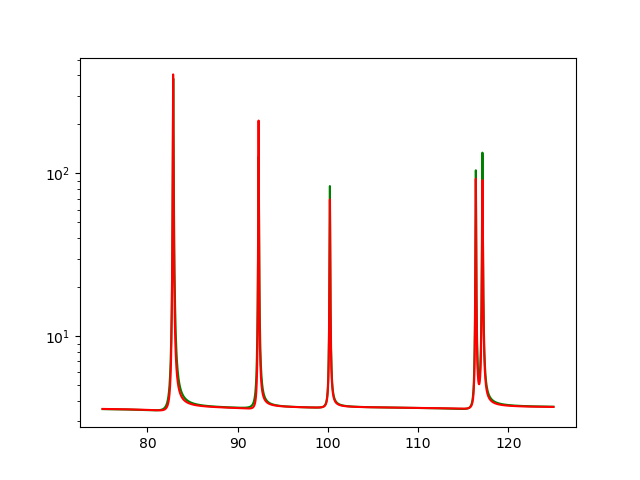

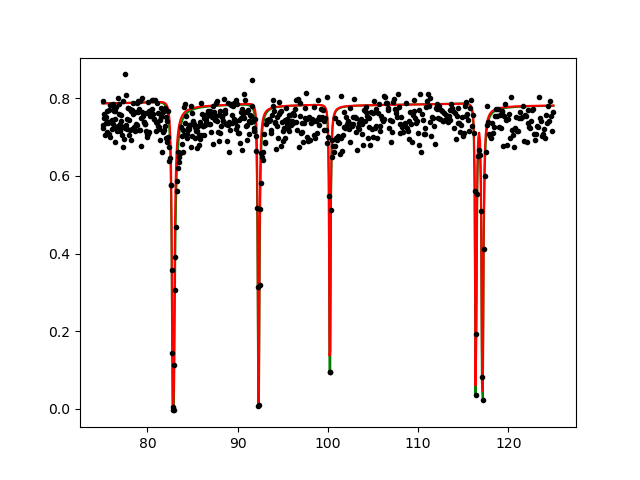

In [ ]:
est_chi_square = (dc.pw.exp.exp_trans-dc.pw.exp.final_trans) @ inv(dc.pw.CovT) @ (dc.pw.exp.exp_trans-dc.pw.exp.final_trans).T
sol_chi_square = (dc.pw.exp.exp_trans-dc.pw.exp.theo_trans) @ inv(dc.pw.CovT) @ (dc.pw.exp.exp_trans-dc.pw.exp.theo_trans).T
from scipy import integrate
est_sol_MSE = integrate.trapezoid((dc.pw.fine.theo_xs-dc.pw.fine.final_xs)**2, dc.pw.fine.E)

print(f'Chi2 estimate to data: {est_chi_square}')
print(f'Chi2 true to data: {sol_chi_square}')
print(f'Integral SE estimate to true: {est_sol_MSE}')


figure()
plot(dc.pw.fine.E, dc.pw.fine.theo_xs, 'g')
plot(dc.pw.fine.E, dc.pw.fine.final_xs, 'r')
yscale('log')
# ylim([0,dc.exp_par.max_xs+100])
figure()
plot(dc.pw.exp.E, dc.pw.exp.theo_trans, 'g')
plot(dc.pw.exp.E, dc.pw.exp.final_trans, 'r')
plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.k')


## Notes

#### Initial uncertainty on parameters in sammy
should be large, we don't have a prior we just want the GLLS to converge.

Fudge factor cant be too larger for numerics:
 - M' = (M^-1 + (G.T @ V^-1 @ G.T) )^-1
 - first term is full rank, second is not guranteed (it is if NEpts>=NPar). Becasue the first term is full rank, then adding it to the second makes the whole thing full rank and therefore invertable. However, if the first term (M^-1 or 1/prior variance) is driven numerically to 0, then you are left with only the second term. If it is not full rank it won't be invertable then the thing will not be numerically stable. 

#### Sammy is not always converging
- could run sammy multiple times?
- also, the problem is resolved when I 'cheat' with the resonance energies. I think having multiple small resonances right on top of one another is causing sammy to run away.


#### Unexpected behavior when finding integer number of resonances
Often times the weight constrained solution for an integer number of resonances will have selected a smaller resonance than expected when there's a larger existing resonance that would drive the chi2 even lower. I believe this is a problem with not finding the maximum weight solution to an integer number of resonances.

- Now I am driving neutron width to the total leaving 0 Gt, currently hard coded max Gn = Gt-0.005

#### LRT
I am currently calculating the likelihood using sts.multivariate_normal.pdf. When trying to calculate it using just the chi2 to the data, I get an error because the determinate of the covariance matrix is 0... This seems incorrect.

Using LRT for nested models only works if the nested parameter are the exact same. I don't beleive that this is the case.

#### Other
- Can cutoff weights at 1e-5 or 6 because this corresponds directly to a neutron width this small of a resonance is insignificant